## Part -1


1. **Load data**
    1. sampling rate 지정
        
        respireNet에서는 4kHz로 down sampling

    2. librosa.load 사용
    
    load 시 sampling rate 파라미터로 전체 data에 일괄 적용 가능

2. **Pre-processing**
    1. raw data cutting
        - 한 호흡 주기에 맞춰서 data 자르기

3. **Data Analysis**
    1. Data  imbalance 확인
    2. 적절한 패딩 시간(초) 분석


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Importing Dependencies

필요한 라이브러리 다운로드

In [17]:
# !pip install tensorflow-io[tensorflow]

In [16]:
# !pip install nlpaug

In [15]:
# !pip install cmapy

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import soundfile as sf
import librosa as lb
import cv2
#import cmapy
import os


In [6]:
#augmentation
import tensorflow_io as tfio
import nlpaug.augmenter.audio as naa

#train_test_val split
from sklearn.model_selection import train_test_split

##1. Load Data

In [ ]:
root = '/content/drive/MyDrive/aiffel/aiffelthon/'
AUTOTUNE = tf.data.experimental.AUTOTUNE
sr = 16000 # sampling rate

In [ ]:
raw_df = pd.read_csv(root + 'csv_data/data.csv')
raw_df.head()

,start,end,crackles,weezels,pid,mode,filename,disease
0,1.862,5.718,0,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
1,5.718,9.725,1,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
2,9.725,13.614,0,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
3,13.614,17.671,0,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
4,17.671,19.541,0,0,160,mc,160_1b3_Al_mc_AKGC417L,COPD


3개의 샘플로 원본 데이터를 확인합니다

In [10]:
wav_show = []
wav_root = root + 'archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
wav_filename = ['157_1b1_Pr_sc_Meditron.wav',
                '154_4b4_Pl_mc_AKGC417L.wav',
                '151_3p2_Tc_mc_AKGC417L.wav']

for idx in range(3):
  audio_2, _= lb.load(wav_root + wav_filename[idx], sr = sr)
  wav_show.append(audio_2)

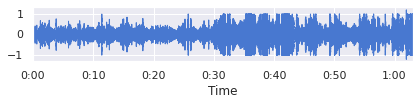

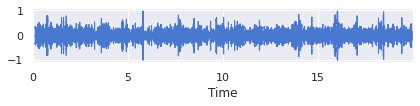

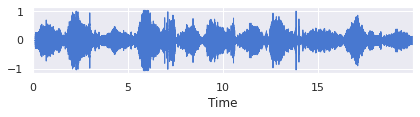

In [11]:
import librosa.display as lbd

sns.set_theme(style="darkgrid")
sns.set_palette("muted")
plt.figure()

for idx in range(3):
  plt.subplot(3,1,idx+1)
  lbd.waveplot(np.array(wav_show, dtype=object)[idx], sr=sr)
  plt.tight_layout()
  plt.show()

In [12]:
from IPython.display import Audio
Audio(wav_show[2], rate = 16000)

## 2. Pre-processing

wav 파일을 start end에 맞게 잘라줍니다

동시에 crackle wheezing에 대한 컬럼을 추가합니다

In [13]:
def getPureSample(raw_data,start,end,sr=22050):
    
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    '''

    max_ind = len(raw_data) #원본 데이터
    start_ind = min(int(start * sr), max_ind) #시작 시간 x sample rate
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

In [ ]:
i,c=0,0

filename2 = []
start2 = []
end2 = []
pid2 = []
mode2 = []
disease2 = []
crack_wheeze = []
for index,row in raw_df.iterrows():
    start=row['start']
    end=row['end']
    filename=row['filename']
    
    # 불러올 파일 경로
    audio_file_loc=root + filename + '.wav'
    
    # 새로운 파일 이름 지정
    if index > 0:
        if raw_df.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav' 

    filename2.append(filename)
    start2.append(row['start'])
    end2.append(row['end'])
    pid2.append(row['pid'])
    mode2.append(row['mode'])
    disease2.append(row['disease'])

    if row['crackles'] == 0 and row['weezels'] == 0:
      crack_wheeze.append(0)
    elif row['crackles'] == 1 and row['weezels'] == 0:
      crack_wheeze.append(1)
    elif row['crackles'] == 0 and row['weezels'] == 1:
      crack_wheeze.append(2)
    else:
      crack_wheeze.append(3)
    
    save_path='/content/drive/MyDrive/aiffel/aiffelthon/processed_audio_files_8/' + filename
    c+=1 #파일 개수 세기
    
    audioArr,sampleRate=lb.load(audio_file_loc, sr = 16000)
    pureSample=getPureSample(audioArr,start,end,sampleRate)
    
    sf.write(file=save_path,data=pureSample,samplerate=sampleRate)
print('Total Files Processed: ',c)

In [ ]:
# crack_wheeze 컬럼이 추가된 새로운 DataFrame
processed = pd.DataFrame(columns=['start','end','pid','mode','filename','disease','crack_wheeze'])
processed['start'] = start2
processed['end'] = end2
processed['pid'] = pid2
processed['mode'] = mode2
processed['filename'] = filename2
processed['disease'] = disease2
processed['crack_wheeze'] = crack_wheeze

processed.to_csv(root + 'processed.csv')

In [14]:
raw_df2 = pd.read_csv(root + 'processed.csv')
raw_df2

,Unnamed: 0,start,end,pid,mode,filename,disease,crack_wheeze
0,0,1.862,5.718,160,mc,160_1b3_Ar_mc_AKGC417L_0.wav,COPD,2
1,1,5.718,9.725,160,mc,160_1b3_Ar_mc_AKGC417L_1.wav,COPD,2
2,2,9.725,13.614,160,mc,160_1b3_Ar_mc_AKGC417L_2.wav,COPD,2
3,3,13.614,17.671,160,mc,160_1b3_Ar_mc_AKGC417L_3.wav,COPD,2
4,4,17.671,19.541,160,mc,160_1b3_Ar_mc_AKGC417L_4.wav,COPD,0
...,...,...,...,...,...,...,...,...
6893,6893,9.393,11.764,159,sc,159_1b1_Pr_sc_Meditron_4.wav,Healthy,0
6894,6894,11.764,14.050,159,sc,159_1b1_Pr_sc_Meditron_5.wav,Healthy,0
6895,6895,14.050,16.521,159,sc,159_1b1_Pr_sc_Meditron_6.wav,Healthy,0
6896,6896,16.521,18.907,159,sc,159_1b1_Pr_sc_Meditron_7.wav,Healthy,0


3개 샘플로 잘린 wavform을 확인합니다

In [ ]:
wav_show = []
wav_filename = ['157_1b1_Pr_sc_Meditron_1.wav',
                '154_4b4_Pl_mc_AKGC417L_5.wav',
                '151_3p2_Tc_mc_AKGC417L_3.wav']

for idx in range(3):
  audio_2, _= lb.load(
      root + 'processed_audio_files_no_pad/' + wav_filename[idx], sr = sr)
  wav_show.append(audio_2)


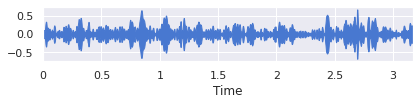

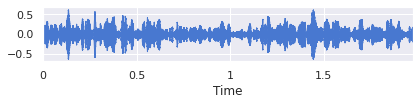

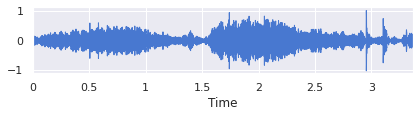

In [ ]:
plt.figure()

for idx in range(3):
  plt.subplot(3,1,idx+1)
  lbd.waveplot(np.array(wav_show, dtype=object)[idx], sr=sr)
  plt.tight_layout()
  plt.show()


In [ ]:
Audio(wav_show[2], rate = 16000)

##3. Data Analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

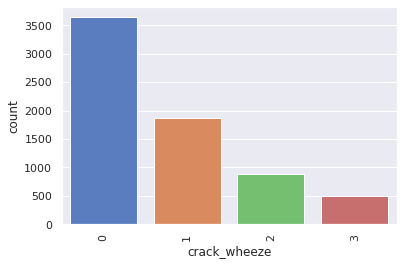

In [ ]:
sns.countplot(raw_df2.crack_wheeze)
plt.xticks(rotation=90)

Data imbalance 확인
- 0 : Normal
- 1 : Crackle
- 2 : Wheeze
- 3 : Crackle & Wheeze


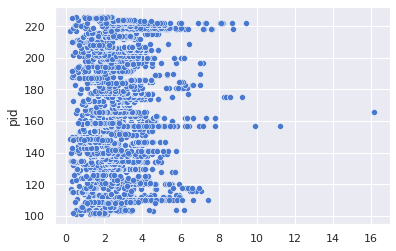

In [ ]:
sns.scatterplot(x=(raw_df2.end-raw_df2.start), y=raw_df2.pid)

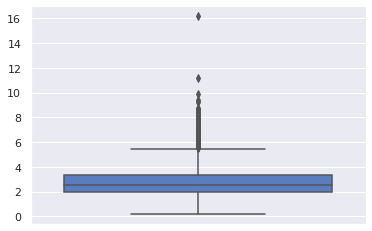

In [ ]:
sns.boxplot(y=(raw_df2.end-raw_df2.start))

호흡주기를 7초로 지정합니다